# Analyse cartes cognitives

Version définitive, pour thèse VB et rapport final CNRT.

## Chargement et préparation du jeu de données

Les données sont stockées dans un fichier `.xls` dans le sous dossier `../input/`.
Il faut transformer l'onglet `BDD` pour le mettre dans un format manipulable.


In [1]:
import operator as op
from collections import defaultdict
from itertools import pairwise

from datetime import date
from pathlib import Path
from pprint import pprint, pformat
from collections import Counter
from statistics import fmean, median
import warnings

# cracra mais on va faire avec
warnings.filterwarnings("ignore")

import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display

from catk import CA  # type: ignore


# nombre max de mots énoncables = nb colonnes source XLS
MAX_COLS = 20
# fichier BDD
# XLS_SOURCE = Path("../input/BDD_2022-06-22.xlsx")
XLS_SOURCE = Path("../input/BDD_2023-07-20.xlsx")

# Noms des onglets
SHEET_THESAURUS = "Thésaurus"
SHEET_BDD = "BDD"
SHEET_QUESTIONS = "Questions"
SHEET_MOTS = "Mots"

# préfixes des colonnes des mots énoncés
PREFIX_MINE = "Mine"
PREFIX_FUTUR = "Futur"

# noms des cartes
LABEL_MINE = "la mine et le nickel"
LABEL_FUTUR = "la mine dans le futur"

TOP_K_WORDS = 20

# mots sans signification, supprimés du thésaurus
INCONNU = "S.i"

# résultats
OUTPUT_FOLDER = Path("../output_v3")
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)

TODAY = date.today().strftime("%Y-%m-%d")

# categories de colonnes dans la BDD : quetionnaire mine, questionnaire futur et informations censurées
# le reste sont les attributs des répondants qu'on utilise dans la suite
cols_mine = [f"{PREFIX_MINE} {i}" for i in range(1, MAX_COLS + 1)]
cols_futur = [f"{PREFIX_FUTUR} {i}" for i in range(1, MAX_COLS + 1)]
cols_censurees = [f"Question {x}" for x in [2, 5.1, 7, 10.1, 11, 14, 14.1]] + ["Commentaire entretien/individu"]


# petit outillage
def clean(s: str) -> str:
    """Nettoyage de chaines"""
    if not isinstance(s, str):
        raise TypeError(f"'{s}' is of type {type(s)}")
    return s.strip().lower()


def pretty_pvals(x):
    """Affichage de courtoisie des niveaux de significativité statistique"""
    if x < 1e-4:
        return "****"
    if x < 1e-3:
        return "***"
    if x < 1e-2:
        return "**"
    if x < 5e-2:
        return "*"
    return ""


'/home/romulus/Documents/unc-scopus-bibliographer/pharmaco-chemistry-biblio/catk/catk/data/data.py' loaded
'/home/romulus/Documents/unc-scopus-bibliographer/pharmaco-chemistry-biblio/catk/catk/data/__init__.py' loaded
'/home/romulus/Documents/unc-scopus-bibliographer/pharmaco-chemistry-biblio/catk/catk/ca.py' loaded
'/home/romulus/Documents/unc-scopus-bibliographer/pharmaco-chemistry-biblio/catk/catk/__init__.py' loaded


### Chargement des données

In [17]:
df_complete = pd.read_excel(XLS_SOURCE, sheet_name=SHEET_BDD, index_col="Numéro")


# ajout des groupes d'ages quinquennaux/décénaux GAD et GAQ
# df_complete["GAD"] = 10 * (df_complete["Question 12"] // 10)
def float_to_inter(f):
    if not np.isfinite(f):
        return f
    return f"{int(f)}-{int(f)+9} ans"

df_complete["GAD"] = [float_to_inter(base_age) for base_age in 10 * (df_complete["Question 12"] // 10)]
# df_complete["GAQ"] = 5 * (df_complete["Question 12"] // 5)

# print(f"Liste des colonnes disponibles dans l'onglet '{SHEET_BDD}' du fichier '{XLS_SOURCE}'")
# display(df_complete.columns)

# les informations des répondants
cols_resp = [c for c in df_complete.columns if c not in cols_mine + cols_futur + cols_censurees]

df_resp = df_complete[cols_resp]
df_resp.name = "Données personnelles"
df_mine = df_complete[cols_mine].astype("string")
df_mine.name = f"Cartes cognitives '{LABEL_MINE}'"
df_futur = df_complete[cols_futur].astype("string")
df_futur.name = f"Cartes cognitives '{LABEL_FUTUR}'"

print(f"Nombre de répondants {len(df_complete)}")
# print(f"Colonnes '{LABEL_MINE}' présentes {set(cols_mine) <= set(df_complete.columns)}")
# print(f"Colonnes '{LABEL_FUTUR}' présentes {set(cols_futur) <= set(df_complete.columns)}")

df_complete


Nombre de répondants 508


,Date,Commune d’enquête,Collecte directe,Commentaire entretien/individu,Question 1,Question 2,Question 3,Question 4,Question 5,Question 5.1,...,Futur 12,Futur 13,Futur 14,Futur 15,Futur 16,Futur 17,Futur 18,Futur 19,Futur 20,GAD
Numéro,,,,,,,,,,,,,,,,,,,,,
1,2021-06-09,Thio,Oui,NaN,Non,NaN,NaN,Oui,Oui,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50-59 ans
2,2021-06-09,Thio,Oui,Très bavard. Directeur du collège public.,Non,NaN,NaN,Non,Non,France (naissance),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60-69 ans
3,2021-06-09,Thio,Oui,NaN,Non,NaN,NaN,Oui,Oui,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30-39 ans
4,2021-06-09,Thio,Oui,NaN,Oui,Géomètre - topographe,15 ans,Oui,Oui,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50-59 ans
5,2021-06-10,Thio,Oui,NaN,Non,NaN,NaN,Oui,Oui,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60-69 ans
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2022-03-10,Hienghène,Oui,Collègien Hienghène,Non,NaN,NaN,Non,Oui,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10-19 ans
505,2022-03-10,Hienghène,Oui,Collègien Hienghène,Non,NaN,NaN,Oui,Oui,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10-19 ans
506,2022-03-10,Hienghène,Oui,Collègien Hienghène,Non,NaN,NaN,Oui,Oui,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10-19 ans


### Informations personnelles des répondants

On utilise l'onglet qui décrit les questions posées aux répondants. 

In [4]:
df_questions = pd.read_excel(XLS_SOURCE, sheet_name=SHEET_QUESTIONS, parse_dates=False).astype(
    {"Question": "string", "Libellé": "string"}
)

print(
    f"Toutes les questions posées bien présentes chez les répondants {set(df_questions['Question']) <= (set(df_resp.columns) | set(cols_censurees))}"
)
display(df_questions)

# mise sous forme de dictionnaire pour remplacer les questions par leurs labels dans les résultats/légendes
questions_labels = df_questions.set_index("Question").to_dict()["Libellé"]  # orient="series"


Toutes les questions posées bien présentes chez les répondants True


,Question,Libellé
0,Question 1,Travaillez-vous ou avez travaillez pour l’indu...
1,Question 2,"Si oui, quel(s) étai(en)t votre/vos poste(s) ?"
2,Question 3,Depuis combien de temps travaillez-vous ou pen...
3,Question 4,Un membre de votre famille travaille t’il ou a...
4,Question 5,Avez-vous toujours vécu en Nouvelle-Calédonie ?
5,Question 5.1,"Si non, d’où venez-vous ?"
6,Question 6,"Si non, depuis combien de temps vivez-vous en ..."
7,Question 7,"Si non, pourquoi vous êtes vous installé(e) en..."
8,Question 8,Où habitez-vous ? (Le plus précis possible san...
9,Question 8.1,Commune de résidence.


### Division du jeu de données

Création des dictionnaires de réponses. On va extraire trois jeux de données :

- `cg_mine` : toutes les réponses aux questions "la mine", enquêtes 2021 **et** 2022
- `cg_mine_2022` : les 104 dernières réponses aux questions "la mine", enquête 2022
- `cg_futur_2022` : les 104 dernières réponses aux questions "la mine dans le futur", enquête 2022

On done quelques statistiques de base pour chaque jeu de données.


In [5]:
def get_cogmaps(df, cols):
    """fonction outil pour transformer le dataframe BDD en dictionnaire des mots énoncés"""
    return {idx: [clean(val) for val in vals.dropna().tolist()] for idx, vals in df[cols].astype("string").iterrows()}

# la restriction à l'année 2022
df_2022 = df_complete[df_complete["Date"].dt.year == 2022]

# les dictionnaires principaux : les Cartes Cognitives
# dictionnaires de la forme : { répondant, list[mots]}
cg_mine_tous = get_cogmaps(df_complete, cols_mine)
cg_mine_2022 = get_cogmaps(df_2022, cols_mine)
cg_futur_2022 = get_cogmaps(df_2022, cols_futur)

CGS = [cg_mine_tous, cg_mine_2022, cg_futur_2022]
PRE_LABELS = [(LABEL_MINE, "tous"), (LABEL_MINE, "2022"), (LABEL_FUTUR, "2022")]
LABELS = [f"{b} ({y})" for b, y in PRE_LABELS]


for cg, lbl in zip(CGS, LABELS):
    print(lbl.capitalize())
    print(f"  nombre de réponses {len(cg)}")
    print(f"  plus longue cartes {max(len(val) for val in cg.values())}")
    print(f"  longueur moyenne des cartes {fmean(len(val) for val in cg.values()):.2f}")
    print(f"  nombre total de mots énoncés {sum(len(val) for val in cg.values())}")
    print(f"  nombre de mots énoncés différents {len(set(v for val in cg.values() for v in val))}")
    print()


La mine et le nickel (tous)
  nombre de réponses 508
  plus longue cartes 20
  longueur moyenne des cartes 7.61
  nombre total de mots énoncés 3865
  nombre de mots énoncés différents 902

La mine et le nickel (2022)
  nombre de réponses 104
  plus longue cartes 20
  longueur moyenne des cartes 6.84
  nombre total de mots énoncés 711
  nombre de mots énoncés différents 335

La mine dans le futur (2022)
  nombre de réponses 104
  plus longue cartes 15
  longueur moyenne des cartes 3.43
  nombre total de mots énoncés 357
  nombre de mots énoncés différents 262



In [6]:
# création des des résumés "positions", qui donnent aussi le nombre de mot
def get_positions(cg: dict[str, list[int]]):
    res = defaultdict(list)
    for i, ws in cg.items():
        for p, w in enumerate(ws):
            # res[w].append(p + 1) # positions absolues
            res[w].append((len(ws) - p) / len(ws)) # positions relatives, en % le la longueur de la carte
    return res


# une position est dictionnaires de la forme : { mot, list[position]}
positions = get_positions(cg_mine_tous)
pos_mine_2022 = get_positions(cg_mine_2022)
pos_futur_2022 = get_positions(cg_futur_2022)

POS = [positions, pos_mine_2022, pos_futur_2022]

# len(pos_mine_tous["nickel"])
print("Position relative maximum, moyenne, mediane et minimum de chaque mot")
for w, ps in pos_mine_2022.items():
    print(f"\t{w} ({len(ps)}): {max(ps):.0%}, {fmean(ps):.0%}, {median(ps):.0%}, {min(ps):.0%}")


Position relative maximum, moyenne, mediane et minimum de chaque mot
	environnement (6): 100%, 80%, 76%, 50%
	destruction environnement (1): 90%, 90%, 90%, 90%
	industriel (1): 80%, 80%, 80%, 80%
	boue (1): 70%, 70%, 70%, 70%
	détruire (1): 60%, 60%, 60%, 60%
	poussière (1): 50%, 50%, 50%, 50%
	salissant (1): 40%, 40%, 40%, 40%
	destruction montagne (1): 30%, 30%, 30%, 30%
	prise de conscience (1): 20%, 20%, 20%, 20%
	reboisement (2): 25%, 18%, 18%, 10%
	destruction de la nature (1): 75%, 75%, 75%, 75%
	richesse (6): 100%, 67%, 76%, 11%
	gagne-pain (1): 25%, 25%, 25%, 25%
	rapporte beaucoup (1): 100%, 100%, 100%, 100%
	tourisme (2): 100%, 93%, 93%, 86%
	cyclique (1): 71%, 71%, 71%, 71%
	sous-traitant (1): 57%, 57%, 57%, 57%
	milliards (1): 43%, 43%, 43%, 43%
	c'est la terre (1): 29%, 29%, 29%, 29%
	épuisement (3): 29%, 22%, 22%, 14%
	pollution (25): 100%, 62%, 57%, 12%
	marché (économique) (1): 100%, 100%, 100%, 100%
	esquinte la nature (1): 75%, 75%, 75%, 75%
	nature (8): 92%, 63%, 58

Calculs des mots énoncés les plus cités à partir du relevé des positions 

In [7]:
for positions, lbl in zip(POS, LABELS):
    print(f"{lbl.capitalize()} : {len(positions)} mots différents. Top {TOP_K_WORDS} :")
    words = Counter({w: len(l) for w, l in positions.items()})
    display(words.most_common(TOP_K_WORDS))


La mine et le nickel (tous) : 902 mots différents. Top 20 :


[('nickel', 189),
 ('pollution', 182),
 ('économie', 116),
 ('camion', 104),
 ('travail', 100),
 ('environnement', 100),
 ('emploi', 97),
 ('usine', 89),
 ('montagne', 77),
 ('argent', 76),
 ('richesse', 74),
 ('terre', 73),
 ('exploitation', 65),
 ('minerai', 65),
 ('destruction', 60),
 ('ressource', 56),
 ('sln', 54),
 ('conflit', 52),
 ('déforestation', 42),
 ('caillou', 38)]

La mine et le nickel (2022) : 335 mots différents. Top 20 :


[('camion', 34),
 ('usine', 29),
 ('pollution', 25),
 ('montagne', 25),
 ('terre', 24),
 ('cailloux', 20),
 ('argent', 18),
 ('métal', 15),
 ('destruction', 11),
 ('travail', 11),
 ('camions', 11),
 ('fer', 10),
 ('nickel', 9),
 ('la terre', 9),
 ('nature', 8),
 ('déforestation', 8),
 ('caillou', 7),
 ('environnement', 6),
 ('richesse', 6),
 ('engin', 6)]

La mine dans le futur (2022) : 262 mots différents. Top 20 :


[('pollution', 10),
 ('plus de montagne', 9),
 ('je ne sais pas', 8),
 ('plus de nickel', 8),
 ('métal', 5),
 ('camion', 5),
 ('montagne', 4),
 ('plus de travailleur', 4),
 ('moins de nickel', 4),
 ('destruction', 3),
 ('environnement', 3),
 ('plus de pollution', 3),
 ('réchauffement climatique', 3),
 ('bâteau', 3),
 ('usine', 3),
 ('éboulement', 3),
 ("plus d'usine", 3),
 ('fin du monde', 3),
 ('cailloux', 3),
 ('déforestation', 3)]

Longueur des cartes et leurs histogrammes


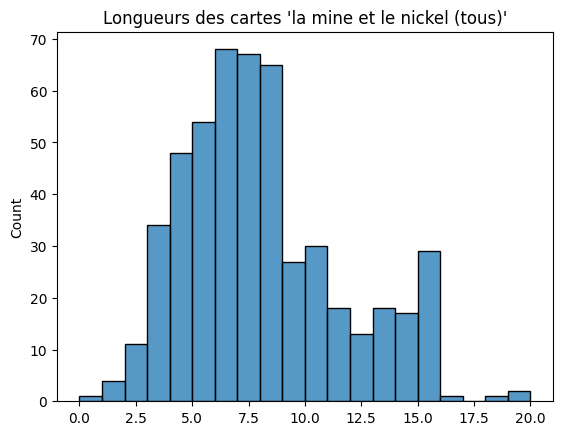

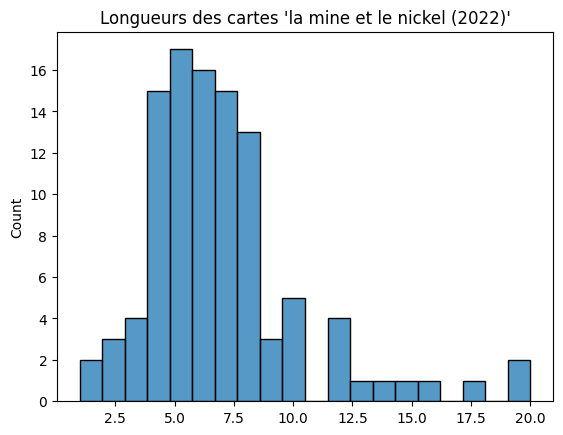

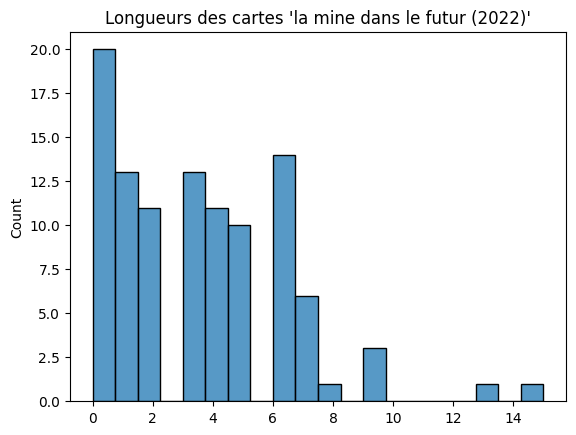

In [8]:
def get_n_words(dic, n: int):
    """Mot de la position n"""
    return [vals[n] for vals in dic.values() if n < len(vals)]

for cg, lbl in zip(CGS, LABELS):
    sns.histplot([len(vals) for vals in cg.values()], bins=20).set(title=f"Longueurs des cartes '{lbl}'")
    plt.show()


## Mots énoncés les plus communs pour la carte "la mine"

On va segmenter les données en _populations_ (e.g., "moins de 26 ans", "mineur", etc.) selon les attributs et générer un tableau avec :

- en ligne tous les mots énoncés dans les cartes "la mine"
- en colonne, les populations, avec pour chacune :
  - le nombre de fois où le mot a été énoncé par les membres de cette population
  - le nombre de fois "théorique" où le mot serait annoncé si il y avait indépendance des énonciations entre les populations
  - le % de fois où un membre de la population a énoncé le mot
- pour chaque groupe, on calcule ensuite un test du $\chi^2$ pour évaluer l'écart à l'indépendance


In [9]:
THRESHOLD_MIN_ENONCIATIONS = 20
LABEL_TOTAL = "Nb. occ."
LABEL_POS_MED = "Pos. médiane"
LABEL_POS_MOY = "Pos. moyenne"
ALL_SYMB = "*"
CLEF_TOTAL = (ALL_SYMB, ALL_SYMB, LABEL_TOTAL)
CLEF_POS_MED = (ALL_SYMB, ALL_SYMB, LABEL_POS_MED)
CLEF_POS_MOY = (ALL_SYMB, ALL_SYMB, LABEL_POS_MOY)

def pos_to_df(words):
    """transformation en DF"""
    df = pd.DataFrame(index=list(words.keys()))
    df[CLEF_TOTAL] = [len(ps) for ps in words.values()]
    df[CLEF_POS_MED] = [round(100 * median(ps),2) for ps in words.values()]
    df[CLEF_POS_MOY] = [round(100 * fmean(ps),2) for ps in words.values()]

    # filtrage au dessus du seuil et tri
    # df = df[df[CLEF_TOTAL] >= threshold]
    df.sort_values(CLEF_TOTAL, key=op.neg, inplace=True)
    return df


pos_to_df(positions)


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
nickel,189,87.50,78.22
pollution,182,57.14,58.47
économie,116,65.15,64.05
camion,104,69.05,67.04
environnement,100,62.50,59.14
...,...,...,...
challenge écologique,1,14.29,14.29
mafia,1,28.57,28.57
modernisation,1,86.67,86.67
valeur culturelle,1,75.00,75.00


## Tableau de comparaison des mots énoncés par profil du répondant

**NB** Ici un gros point méthodologique : on va faire un test d'indépendance statistique $\chi^2$ sur les mots énoncés les plus fréquents afin de déterminer si leurs énonciations sont indépendantes ou pas des profils des répondants.

D'abord le gros code.

In [18]:
def add_population(df_population, filtres, name):
    """Ajout de colonnes au df de synthèse des profils sur une population segmentée"""
    observed = []
    expected = []
    chi2 = stats.chi2(len(filtres) - 1)
    for filtre, val in filtres:
        cg = get_cogmaps(df_mine[filtre], cols_mine)
        c = Counter(w for l in cg.values() for w in l)
        # print(f"Ajout de la colonne '{name}, {val}', {len(cg)} répondants, {c.total()} énonciations")

        key = (name, val, "Nb.")
        df_population[key] = pd.Series(c)
        df_population[key].fillna(0, inplace=True)
        df_population[key] = df_population[key].astype(int)


        # ici en % ** des répondants**
        df_population[(name, val, "Nb. th.")] = round(df_population[CLEF_TOTAL] * len(cg) / len(df_mine), 2)
        exp = df_population[CLEF_TOTAL].to_numpy() * len(cg) / len(df_mine)

        observed.append(df_population[key].to_numpy().reshape(-1, 1))
        expected.append(exp.reshape(-1, 1))

    obs, exp = np.concatenate(observed, axis=1), np.concatenate(expected, axis=1)
    chis = np.sum((obs - exp) ** 2 / exp, axis=1)
    p_vals = chi2.sf(chis)
    df_population[(name, "Chi²", "Significatif")] = [pretty_pvals(v) for v in p_vals]


def generate_all_filters(col):
    values = df_resp[col].dropna().unique()
    return [(df_resp[col] == value, value) for value in values]



In [19]:
def prepare(positions, title, threshold=THRESHOLD_MIN_ENONCIATIONS):
    df_enonces = pos_to_df(positions)

    moins_de_26_ans = df_resp["Question 12"] < 26
    add_population(df_enonces, [(moins_de_26_ans, "Oui"), (~moins_de_26_ans, "Non")], "Age < 26")
    add_population(df_enonces, generate_all_filters("Question 13"), "Genre")
    add_population(df_enonces, generate_all_filters("Question 1"), "Travaille dans la mine")
    add_population(df_enonces, generate_all_filters("Question 4"), "Famille dans la mine")
    add_population(df_enonces, generate_all_filters("Question 5"), "Toujours vécu en NC")
    add_population(df_enonces, generate_all_filters("Question 8.2"), "Commune minière")

    # nettoyage final
    df_enonces.fillna(0.0, inplace=True)
    df_enonces.columns = pd.MultiIndex.from_tuples(df_enonces.columns)
    df_enonces.columns.set_names(["Variable", "Catégorie", "Statistique"], inplace=True)

    df_enonces.to_excel(OUTPUT_FOLDER / f"analyse_par_population-{title}-{TODAY}.xlsx")

    return df_enonces


for positions, lbl in zip(POS, LABELS):
    df = prepare(positions, lbl, 10)
    print(f"Analyse des mots par population pour la carte '{lbl.capitalize()}'")
    display(df)


Analyse des mots par population pour la carte 'La mine et le nickel (tous)'


Variable                      *                           Age < 26          \
Catégorie                     *                                Oui           
Statistique            Nb. occ. Pos. médiane Pos. moyenne      Nb. Nb. th.   
nickel                      189        87.50        78.22      151  135.43   
pollution                   182        57.14        58.47      118  130.41   
économie                    116        65.15        64.05       80   83.12   
camion                      104        69.05        67.04       92   74.52   
environnement               100        62.50        59.14       60   71.65   
...                         ...          ...          ...      ...     ...   
challenge écologique          1        14.29        14.29        0    0.72   
mafia                         1        28.57        28.57        0    0.72   
modernisation                 1        86.67        86.67        0    0.72   
valeur culturelle             1        75.00        75.00        1    0.72   
pollution de la nature        1        12.50        12.50        1    0.72   

Variable                                        Genre          ...  \
Catégorie              Non                 Chi² Homme          ...   
Statistique            Nb. Nb. th. Significatif   Nb. Nb. th.  ...   
nickel                  38   53.57            *    81   84.08  ...   
pollution               64   51.59            *    91   80.97  ...   
économie                36   32.88                 52   51.61  ...   
camion                  12   29.48          ***    41   46.27  ...   
environnement           40   28.35           **    47   44.49  ...   
...                     ..     ...          ...   ...     ...  ...   
challenge écologique     1    0.28                  0    0.44  ...   
mafia                    1    0.28                  1    0.44  ...   
modernisation            1    0.28                  0    0.44  ...   
valeur culturelle        0    0.28                  0    0.44  ...   
pollution de la nature   0    0.28                  1    0.44  ...   

Variable               Toujours vécu en NC                       \
Catégorie                              Non                 Chi²   
Statistique                            Nb. Nb. th. Significatif   
nickel                                  40   39.06                
pollution                               41   37.62                
économie                                26   23.98                
camion                                   6   21.50          ***   
environnement                           25   20.67                
...                                    ...     ...          ...   
challenge écologique                     1    0.21                
mafia                                    1    0.21                
modernisation                            0    0.21                
valeur culturelle                        0    0.21                
pollution de la nature                   0    0.21                

Variable               Commune minière                                    \
Catégorie                      Minière         Mixte         Non minière   
Statistique                        Nb. Nb. th.   Nb. Nb. th.         Nb.   
nickel                              53   55.06    67   43.16          68   
pollution                           61   53.02    41   41.56          80   
économie                            39   33.80    42   26.49          35   
camion                              22   30.30    21   23.75          61   
environnement                       30   29.13    34   22.83          36   
...                                ...     ...   ...     ...         ...   
challenge écologique                 1    0.29     0    0.23           0   
mafia                                1    0.29     0    0.23           0   
modernisation                        1    0.29     0    0.23           0   
valeur culturelle                    0    0.29     1    0.23           0   

Analyse des mots par population pour la carte 'La mine et le nickel (2022)'


Variable                      *                           Age < 26          \
Catégorie                     *                                Oui           
Statistique            Nb. occ. Pos. médiane Pos. moyenne      Nb. Nb. th.   
camion                       34        75.00        67.58       92   24.36   
usine                        29        62.50        64.01       83   20.78   
pollution                    25        57.14        62.24      118   17.91   
montagne                     25        66.67        64.56       61   17.91   
terre                        24        66.67        61.73       60   17.20   
...                         ...          ...          ...      ...     ...   
mal de dos                    1        55.00        55.00        1    0.72   
?                             1        70.00        70.00        1    0.72   
dynamite                      1        80.00        80.00        3    0.72   
bien payé                     1        20.00        20.00        1    0.72   
pollution de la nature        1        12.50        12.50        1    0.72   

Variable                                        Genre          ...  \
Catégorie              Non                 Chi² Homme          ...   
Statistique            Nb. Nb. th. Significatif   Nb. Nb. th.  ...   
camion                  12    9.64         ****    41   15.13  ...   
usine                    6    8.22         ****    33   12.90  ...   
pollution               64    7.09         ****    91   11.12  ...   
montagne                16    7.09         ****    27   11.12  ...   
terre                   13    6.80         ****    34   10.68  ...   
...                     ..     ...          ...   ...     ...  ...   
mal de dos               0    0.28                  1    0.44  ...   
?                        0    0.28                  1    0.44  ...   
dynamite                 0    0.28           **     2    0.44  ...   
bien payé                0    0.28                  1    0.44  ...   
pollution de la nature   0    0.28                  1    0.44  ...   

Variable               Toujours vécu en NC                       \
Catégorie                              Non                 Chi²   
Statistique                            Nb. Nb. th. Significatif   
camion                                   6    7.03         ****   
usine                                   15    5.99         ****   
pollution                               41    5.17         ****   
montagne                                 8    5.17         ****   
terre                                   10    4.96         ****   
...                                    ...     ...          ...   
mal de dos                               0    0.21                
?                                        0    0.21                
dynamite                                 0    0.21            *   
bien payé                                0    0.21                
pollution de la nature                   0    0.21                

Variable               Commune minière                                    \
Catégorie                      Minière         Mixte         Non minière   
Statistique                        Nb. Nb. th.   Nb. Nb. th.         Nb.   
camion                              22    9.91    21    7.76          61   
usine                               18    8.45    21    6.62          50   
pollution                           61    7.28    41    5.71          80   
montagne                            19    7.28    14    5.71          44   
terre                               13    6.99     9    5.48          51   
...                                ...     ...   ...     ...         ...   
mal de dos                           0    0.29     0    0.23           1   
?                                    0    0.29     0    0.23           1   
dynamite                             2    0.29     0    0.23           1   
bien payé                            0    0.29     0    0.23           1   

Analyse des mots par population pour la carte 'La mine dans le futur (2022)'


Variable                                    *                            \
Catégorie                                   *                             
Statistique                          Nb. occ. Pos. médiane Pos. moyenne   
pollution                                  10        55.00        60.53   
plus de montagne                            9        66.67        64.44   
je ne sais pas                              8       100.00        93.75   
plus de nickel                              8        73.33        68.33   
métal                                       5        76.92        60.38   
...                                       ...          ...          ...   
moins d'espèces animales                    1        50.00        50.00   
moins de nickel dans le sol                 1        33.33        33.33   
plus de mine dans le monde                  1        16.67        16.67   
soleil                                      1        50.00        50.00   
engin plus gros et plus sophistiqués        1        50.00        50.00   

Variable                             Age < 26                      \
Catégorie                                 Oui         Non           
Statistique                               Nb. Nb. th. Nb. Nb. th.   
pollution                                 118    7.17  64    2.83   
plus de montagne                            0    6.45   0    2.55   
je ne sais pas                              0    5.73   0    2.27   
plus de nickel                              0    5.73   0    2.27   
métal                                      24    3.58   1    1.42   
...                                       ...     ...  ..     ...   
moins d'espèces animales                    0    0.72   0    0.28   
moins de nickel dans le sol                 0    0.72   0    0.28   
plus de mine dans le monde                  0    0.72   0    0.28   
soleil                                      0    0.72   0    0.28   
engin plus gros et plus sophistiqués        0    0.72   0    0.28   

Variable                                          Genre          ...  \
Catégorie                                    Chi² Homme          ...   
Statistique                          Significatif   Nb. Nb. th.  ...   
pollution                                    ****    91    4.45  ...   
plus de montagne                               **     0    4.00  ...   
je ne sais pas                                 **     0    3.56  ...   
plus de nickel                                 **     0    3.56  ...   
métal                                        ****    13    2.22  ...   
...                                           ...   ...     ...  ...   
moins d'espèces animales                              0    0.44  ...   
moins de nickel dans le sol                           0    0.44  ...   
plus de mine dans le monde                            0    0.44  ...   
soleil                                                0    0.44  ...   
engin plus gros et plus sophistiqués                  0    0.44  ...   

Variable                             Toujours vécu en NC                       \
Catégorie                                            Non                 Chi²   
Statistique                                          Nb. Nb. th. Significatif   
pollution                                             41    2.07         ****   
plus de montagne                                       0    1.86           **   
je ne sais pas                                         0    1.65           **   
plus de nickel                                         0    1.65           **   
métal                                                  3    1.03         ****   
...                                                  ...     ...          ...   
moins d'espèces animales                               0    0.21                
moins de nickel dans le sol                            0    0.21                
plus de mine dans le monde                             0    0.21                
s

## Thésaurus

On ne va garder que certaines colonnes du thésaurus.

In [20]:
df_thesaurus = pd.read_excel(XLS_SOURCE, sheet_name=SHEET_THESAURUS)
# un dicitonnaire Concept -> Mot énoncé
thesaurus = {
    key: [str(val) for val in vals if val is not np.nan] for key, vals in df_thesaurus.to_dict(orient="list").items()
}

# print("Liste des concepts du thésaurus")
# display(sorted(thesaurus.keys()))

# print(f"Exemple de mots associés au concept 'Termes positifs' du thésaurus")
# thesaurus["Termes positifs"]

all_words_thesaurus = [val for vals in thesaurus.values() for val in vals]
lengths = {k: len(vals) for k, vals in thesaurus.items()}
# colonne excel "AL" = 26 + 12 = 38 colonnes
print(f"Nombre de concepts dans le thésaurus = {len(thesaurus)}")
print(f"Nombre de mots du thésaurus par concept =\n{[(k,len(vals)) for k, vals in thesaurus.items()]}")
# print(f"Nombre de mots du thésaurus par concept =\n{lengths}")
print(f"Nombre total de mots du thésaurus = {len(all_words_thesaurus)}")
print(f"Nombre de mots intermédiaires du thésaurus sans doublons = {len(set(all_words_thesaurus))}")
print(f"Doublons intermédiaires dans le thésaurus = {len(all_words_thesaurus) != len(set(all_words_thesaurus))}")


concepts_positifs = [
    "Valeurs sociales et interactions positives",
    "Avantage-bénéfice économique et financier",
    "Termes positifs",
    "Actions compensatoires du secteur minier",
]
concepts_negatifs = [
    "Avis péjoratifs et interactions négatives",
    "Épuisement des ressources naturelles",
    "Dégradation-impact environnemental négatif",
    "Action de détruire - dégrader - transformer",
    "Termes négatifs",
]
concepts_ambivalents = ["Avis ambivalent", "Champ lexical de l'incertitude"]

concepts_retenus = concepts_positifs + concepts_negatifs + concepts_ambivalents


Nombre de concepts dans le thésaurus = 38
Nombre de mots du thésaurus par concept =
[('Ressources terrestres', 41), ('Avis péjoratifs et interactions négatives', 57), ('Ressources marines', 9), ('Acteurs, institutions, société', 32), ('Valeurs sociales et interactions positives', 39), ('Actions compensatoires du secteur minier', 25), ('Territoire ', 67), ('Épuisement des ressources naturelles', 13), ('Diversification', 18), ('Avantage-bénéfice économique et financier', 54), ('Paysage minier', 27), ('Dégradation-impact environnemental négatif', 56), ('Secteur extractif et industriel du nickel', 156), ('Ressource nickel', 98), ('Lieux du territoire minier', 22), ('Lieux du territoire non minier', 2), ('Action de détruire - dégrader - transformer', 6), ("Vocubulaire technique lié à l'extraction", 48), ('Vocabulaire technique lié à la métallurgie', 38), ('Avis ambivalent', 8), ('Termes négatifs', 88), ("Champ lexical de l'incertitude", 13), ('Développement durable', 31), ('Évolution de la 

In [24]:
# # TODO : si S.i oon peut suppr, si vide on reprend le mot énoncés

# df_mots = pd.read_excel(XLS_SOURCE, sheet_name=SHEET_MOTS, header=0, usecols="A:B", index_col="Énoncé")
# print("Liste des mots du premier niveau du thésaurus (nettoyage simple)")
# dict_intermediaire = {
#     clean(k): clean(v) if v is not np.nan else clean(k) for k, v in df_mots["Intermédiaire"].to_dict().items()
# }
# display(dict_intermediaire)


## Application des cartes

**A voir** si on garde le premier niveau de nettoyage du thésaurus : alors le faire au plus tôt.


In [25]:
# dict_thesaurus = {v: k for k, vs in thesaurus.items() for v in vs}

# # TODO
# def subst(s: str, *, level: int = 2):
#     """la substitution sinon, le mot d'origine. Voir le "sens inconnu" """
#     if level < 1:
#         return s

#     mot = dict_intermediaire.get(s, s)
#     if level == 1:
#         return mot

#     return dict_thesaurus.get(mot, mot)

# dict_mine_concept = {k: [subst(v) for v in vs] for k, vs in cg_mine_tous.items()}
# dict_mine_concept


## Analyse des correspondances des mots énoncés

On commence par faire l'analyse sur les mots énoncés, ensuite, on fera avec les concepts du thésaurus.


In [13]:
# nombre de fois ou un mot dois être cité toute classe confondues
ROW_THRESHOLD = 3
# nombre de mots cités pour la valeur de la catégorie
COL_THRESHOLD = 30

def gen_ca_dataset(cartes : dict[str, list[str]], attribut:str, min_row = ROW_THRESHOLD, min_col = COL_THRESHOLD):
    """Génère un DataFrame au format requis pour une analyse des correspondances. l'attribut est une des questions"""
    
    # pour chaque mot énoncé, le nombre d'occurrences
    all_words = Counter(w for l in cartes.values() for w in l)

    # toutes les valeurs de la catégorie
    cats = df_complete[attribut].dropna().unique()
    # on génère les filtres : pour chaque valeur de la catégorie, les cartes considérées
    cats_filters = {value: (df_resp[attribut] == value) for value in cats}

    # on prépare le DF résultat avec comme index tous les mots cotés
    df = pd.DataFrame(index=all_words)

    for group in sorted(cats_filters.keys()):
        ids = cats_filters[group].index[cats_filters[group]].to_list()
        cogs = Counter(mot for num, mots in cartes.items() if num in ids for mot in mots)
        # print(f"Groupe {group} :  {len(ids)} individus, {len(cogs)} mots énoncés")
        df[group] = pd.Series(cogs)

    df = df.fillna(0).astype(int)
    df.columns.name = questions_labels.get(attribut, attribut)
    df.index.name = "Mot énoncé"

    # on filtre les mots énoncés au moins 20x pour les classes qui énoncent au moins 100 mots
    row_margin = df.sum(axis=1)
    col_margin = df.sum(axis=0)
    
    return df.loc[row_margin > min_row, col_margin > min_col]


GAD,10-19 ans,20-29 ans,30-39 ans,40-49 ans,50-59 ans,60-69 ans
Mot énoncé,,,,,,
pollution,69,59,13,10,20,8
travail,39,37,6,6,8,4
richesse,24,29,5,4,6,3
destruction,17,20,6,3,7,5
argent,30,18,8,5,11,3
nickel,82,77,8,5,13,1
production,5,1,0,1,3,0
nature,9,5,3,1,8,1
extraction,12,6,1,1,1,1


,Inertia (abs),Chi²,Inertia (%),Cumulated (%)
Axes,,,,
1,0.111469,254.372738,54.530650,54.530650
2,0.034384,78.465038,16.820787,71.351436
3,0.027888,63.639419,13.642574,84.994010
4,0.017581,40.120915,8.600841,93.594851
5,0.013093,29.878521,6.405149,100.000000


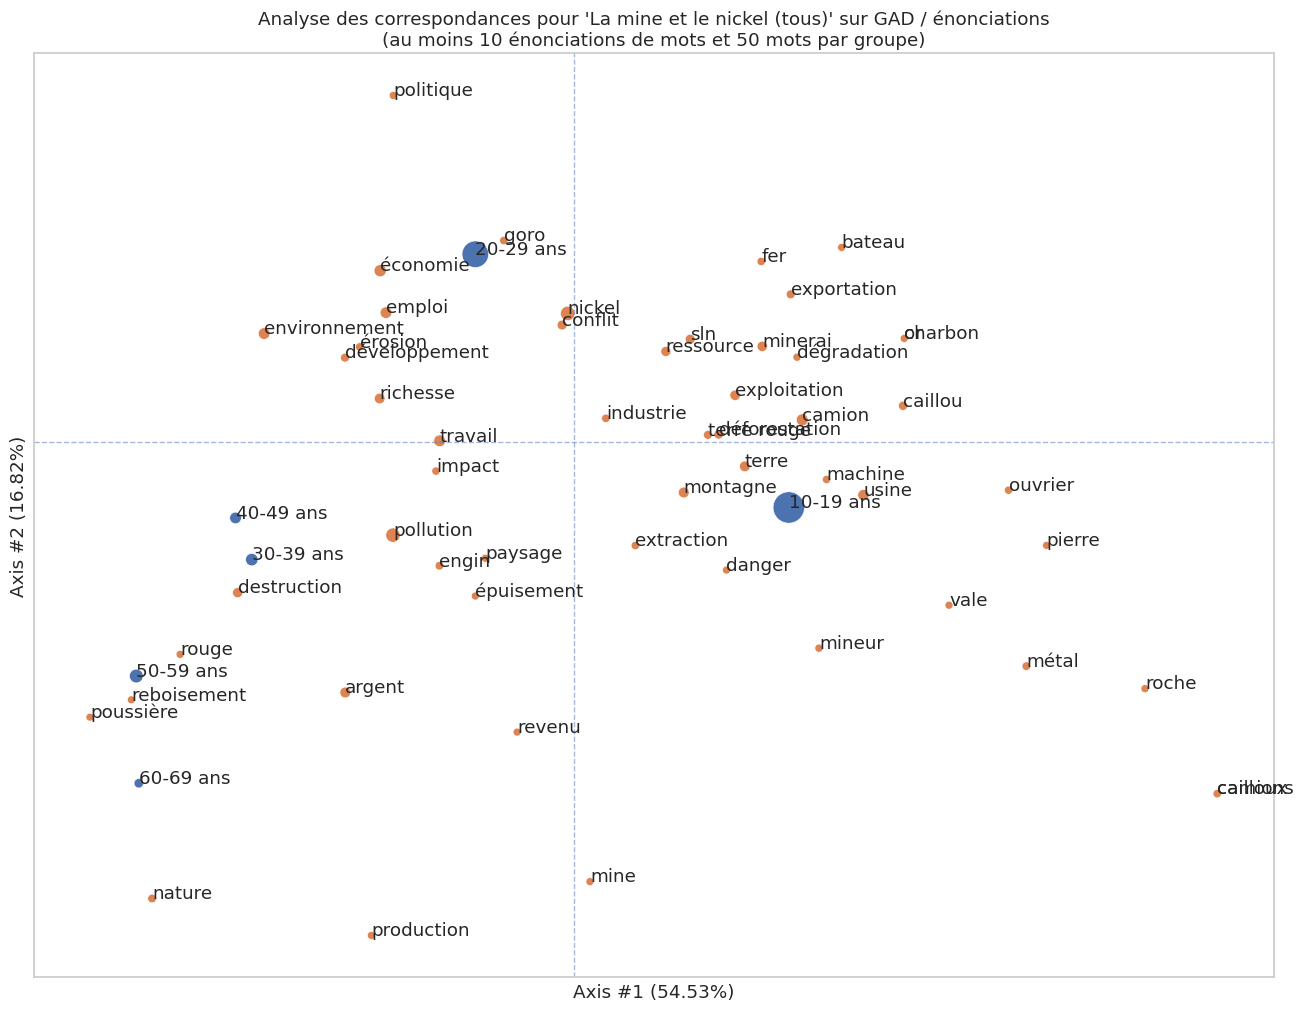

Commune de résidence.,Bourail,Dumbéa,Hienghène,Koné,Lifou,Mont-Dore,Nouméa,Païta,Thio,Touho,Yaté
Mot énoncé,,,,,,,,,,,
pollution,3,24,26,4,3,27,36,16,11,0,16
travail,0,18,10,2,5,8,22,11,6,1,9
richesse,0,14,7,0,0,9,22,9,3,0,2
destruction,2,10,9,2,1,11,10,3,2,1,1
argent,1,8,16,2,1,10,11,5,4,1,9
nickel,5,25,10,4,5,44,63,11,2,2,1
production,0,1,0,0,0,3,4,1,2,0,0
nature,1,1,8,0,1,3,2,5,1,0,3
extraction,2,3,0,1,0,7,6,0,1,0,1


,Inertia (abs),Chi²,Inertia (%),Cumulated (%)
Axes,,,,
1,0.215146,449.009977,49.134119,49.134119
2,0.075858,158.316033,17.324156,66.458275
3,0.029866,62.330483,6.820680,73.278954
4,0.027125,56.609707,6.194669,79.473623
5,0.023133,48.278161,5.282967,84.756590
6,0.018194,37.971540,4.155137,88.911728
7,0.015016,31.337732,3.429215,92.340943
8,0.013037,27.207665,2.977272,95.318215
9,0.010404,21.713328,2.376039,97.694254


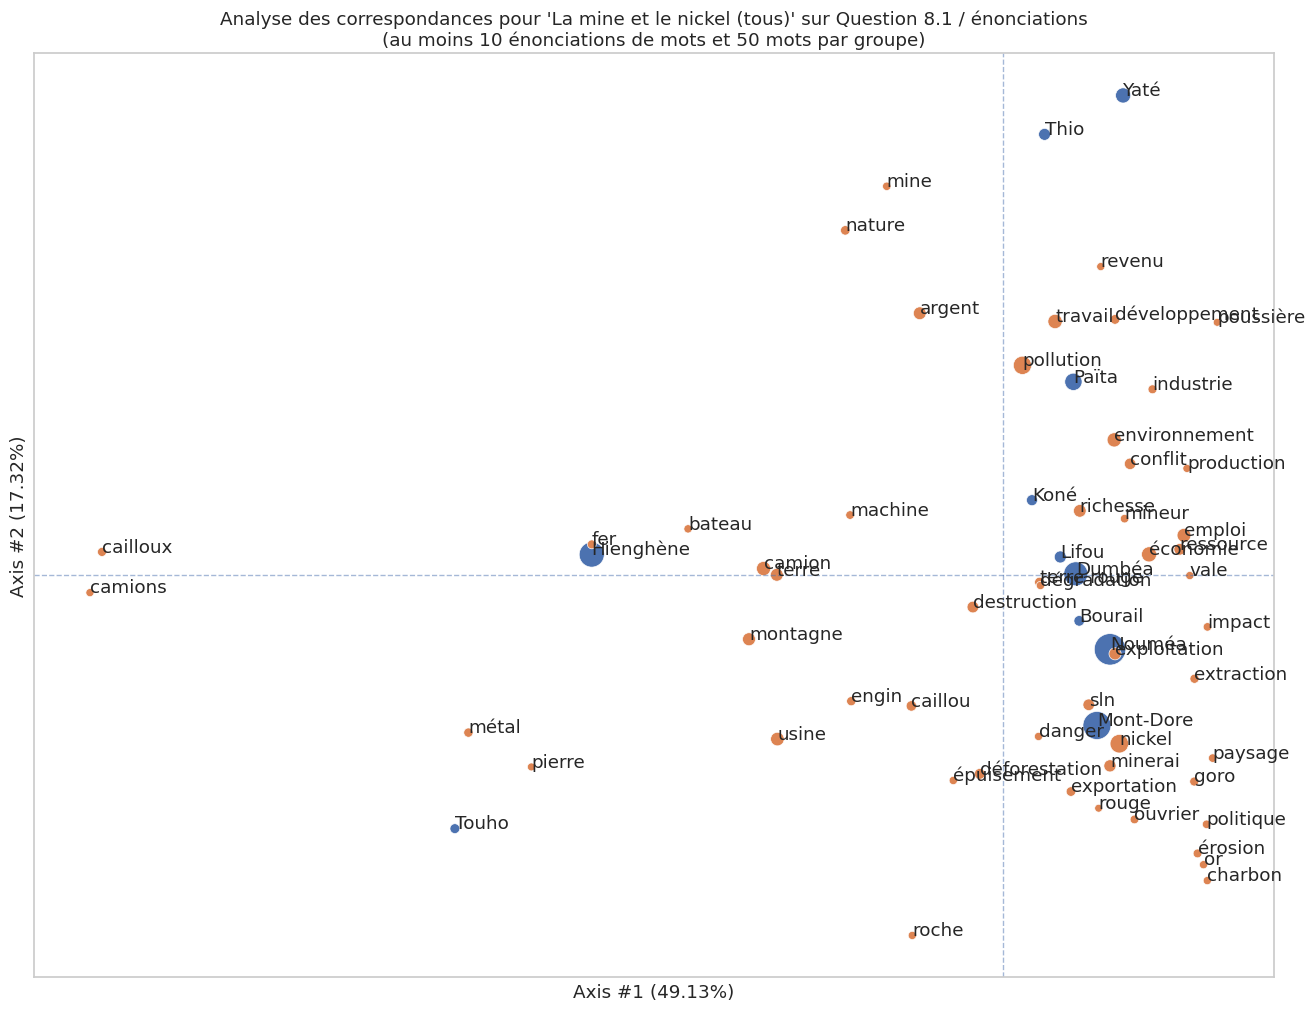

GAD,10-19 ans,20-29 ans,30-39 ans,50-59 ans,60-69 ans
Mot énoncé,,,,,
environnement,1,2,1,1,0
richesse,4,1,0,0,0
pollution,15,2,3,1,2
nature,1,1,1,3,1
économie,2,1,1,0,0
destruction,1,2,2,3,3
terre,19,2,1,1,1
travail,6,1,2,0,2
argent,9,3,2,3,1


,Inertia (abs),Chi²,Inertia (%),Cumulated (%)
Axes,,,,
1,0.449545,158.239761,72.107899,72.107899
2,0.084388,29.704596,13.536016,85.643915
3,0.065427,23.030220,10.494586,96.138501
4,0.024074,8.474005,3.861499,100.000000


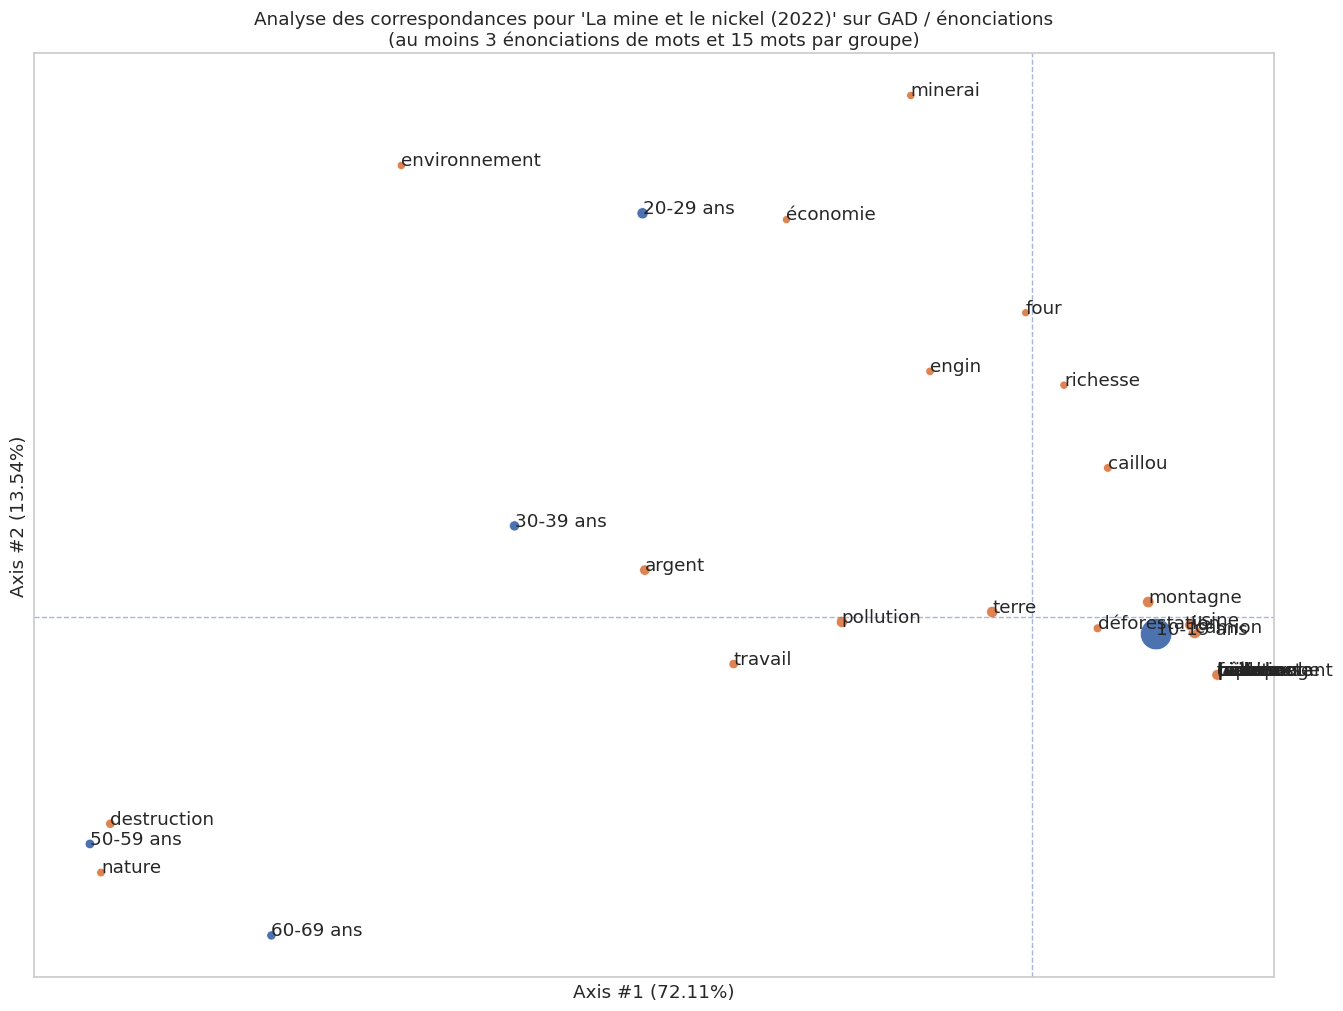

Commune de résidence.,Hienghène,Touho
Mot énoncé,,
environnement,5,0
richesse,6,0
pollution,25,0
nature,8,0
économie,4,0
destruction,9,1
terre,21,3
travail,9,1
argent,16,1


Impossible de représenter : pas assez de données pour la mine et le nickel (2022) de dimension 34x2


GAD,10-19 ans,30-39 ans,50-59 ans
Mot énoncé,,,
je ne sais pas,0,1,1
plus de montagne,8,1,0
pollution,10,0,0
montagne,4,0,0
métal,5,0,0
plus de nickel,8,0,0
plus de travailleur,4,0,0
moins de nickel,4,0,0
camion,5,0,0


,Inertia (abs),Chi²,Inertia (%),Cumulated (%)
Axes,,,,
1,0.756435,38.578206,96.111794,96.111794
2,0.030602,1.560683,3.888206,100.000000


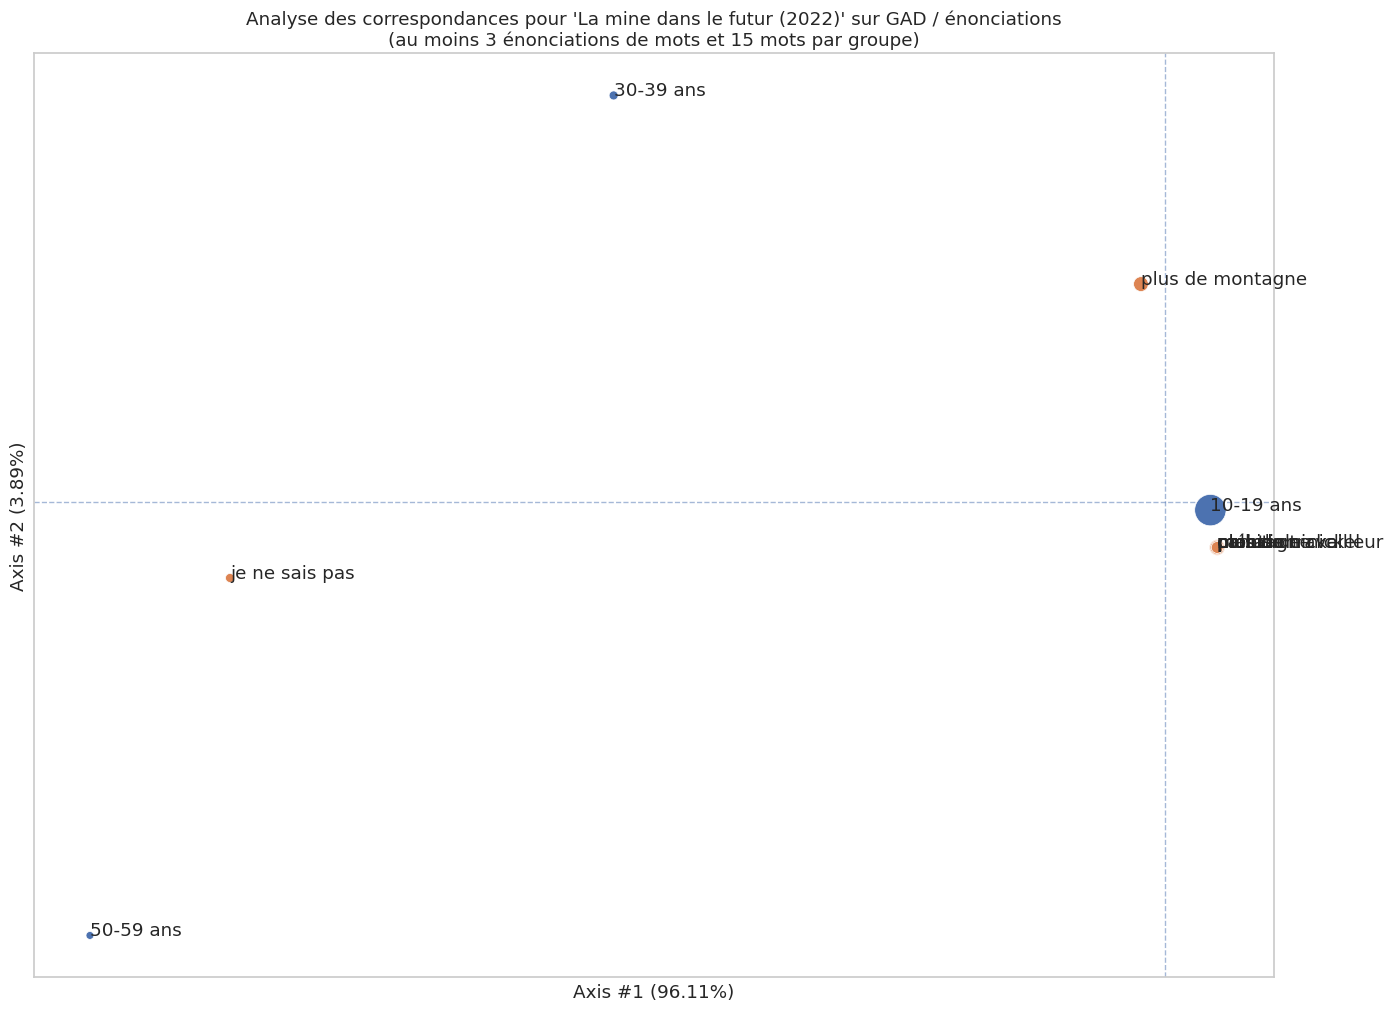

Commune de résidence.,Hienghène,Touho
Mot énoncé,,
je ne sais pas,8,0
plus de montagne,8,1
pollution,8,2
montagne,3,1
métal,5,0
plus de nickel,7,1
plus de travailleur,4,0
moins de nickel,4,0
camion,4,1


Impossible de représenter : pas assez de données pour la mine dans le futur (2022) de dimension 9x2


In [23]:
sns.set_theme(style="whitegrid", font_scale=1.10, rc={"figure.figsize": (16, 12)})
ca = CA(42)

MIN_ROWS = (10, 3, 3)
MIN_COLS = (50, 15, 15)


# for cg, lbl, row, col in zip(CGS, LABELS, MIN_ROWS, MIN_COLS):
#     df = gen_ca_dataset(cg, "GAD", row, col)
#     display(df)


for cg, lbl, row, col in zip(CGS, LABELS, MIN_ROWS, MIN_COLS):
    for attribut in ["GAD", "Question 8.1"]:  # , 
        df = gen_ca_dataset(cg, attribut, row, col)
        display(df)
        if len(df.columns) <= 2 or len(df) <= 2:
            print(
                f"Impossible de représenter : pas assez de données pour {lbl} de dimension {len(df)}x{len(df.columns)}"
            )
            continue
        # display(ref.sort_index())
        ca.fit(df)
        display(ca.axes())
        ca.plot(coords=("principal", "principal"), legend=None).set(
            title=f"Analyse des correspondances pour '{lbl.capitalize()}' sur {attribut} / énonciations\n(au moins {row} énonciations de mots et {col} mots par groupe)"
        )
        plt.show()


## Distribution des énonciations

On commence par représenter le nombre de mots en fonction du nombre de citations sur une échelle logarithme-logarithme.
Clairement la majorité des mots (plus de 800) ne sont cités qu'une seule fois, mais on veut vérifier si la loi type Zipf est vérifiée sur le jeu de données.

In [24]:
def compute_histogramme_occurence(positions):
    """Transforme le dict des positions en un dict N.Occ. -> [mots]"""
    res = defaultdict(list)
    for word, positions in positions.items():
        res[len(positions)].append(word)
    return res

OCC_INV = [compute_histogramme_occurence(pos) for pos in POS]


In [26]:

def mot_enonces_plus_de_k_fois(positions, k):
    """renvoie le nb de mots au dessus du seuil et le nombre d'énonciations"""
    d = Counter({w: len(pos) for w, pos in positions.items() if len(pos) >= k})
    inv = compute_histogramme_occurence(positions)
    return len(d), d.total(), inv[k]


# mot_enonces_plus_de_k_fois(pos_mine_tous, 3)
# nb_max_enonciations = list(all_words_mine.most_common(1))[0][1]
# nb_max_enonciations

(210,
 3067,
 ['inondation',
  'blocage',
  'international',
  'revendication',
  'produit chimique',
  'propriété',
  'poisson',
  'cheminée',
  'sud',
  'ftn',
  'risque',
  'jules garnier',
  'polluant',
  'sous-traitant',
  'important',
  'appauvrissement',
  'multinationale',
  'crayon',
  'eramet',
  'territoire',
  'indépendance',
  'serpentine',
  'tunnel',
  'conséquence',
  'diamant',
  'investissement',
  'marché (économique)',
  'valeur',
  'dynamite',
  'développement durable',
  'népoui',
  'thio',
  'côte ouest',
  'granite',
  'lieu',
  'surexploitation',
  'croissance',
  'terre coutumière',
  'dette',
  'profit',
  'population',
  'barrage',
  'chine',
  'chargement',
  'productivité',
  'rivière',
  'rivière rouge',
  'uniforme',
  'garçon',
  'fille',
  'construction',
  'homme',
  'koné',
  'lave'])

In [34]:
def generate_distribution(positions, label):

    nb_mots_total = len(positions)
    nb_enonciations_total = sum(len(ps) for ps in positions.values())

    res = []
    # for i in range(1, nb_max_enonciations+1):
    for i in sorted(set(len(ps) for ps in positions.values())):
        nb_mots, nb_enonciations, mots = mot_enonces_plus_de_k_fois(positions, i)
        row = (
            i,
            nb_mots,
            round(100 * nb_mots / nb_mots_total, 1),
            nb_enonciations,
            round(100 * nb_enonciations / nb_enonciations_total, 1),
            len(mots),
            round(100 * len(mots) / nb_mots_total, 1),
            sorted(mots)
            # ",".join(sorted(mots)),
        )
        res.append(row)

    columns = [
        "nb occurrences",
        "total mots",
        "% total mots",
        "total énonciations",
        "% total énonciations",
        "nb mots",
        "% nb mots",
        "mots",
    ]
    df_distribution = pd.DataFrame(res, columns=columns)  # .set_index("nb occurrences")
    df_distribution.name = f"Distribution des énonciations pour '{lbl.capitalize()}'"
    df_distribution.to_excel(OUTPUT_FOLDER / f"analyse_distribution_enonciations-{label}-{TODAY}.xlsx")
    return df_distribution

for pos, lbl in zip(POS, LABELS):
    df = generate_distribution(pos, lbl)
    print(df.name)
    display(df)


Distribution des énonciations pour 'La mine et le nickel (tous)'


,nb occurrences,total mots,% total mots,total énonciations,% total énonciations,nb mots,% nb mots,mots
0,1,902,100.0,3865,100.0,586,65.0,"[7 nains, ?, abus, achat, acheminement, activi..."
1,2,316,35.0,3279,84.8,106,11.8,"[acide, agriculture, amélioration, ancêtre, ar..."
2,3,210,23.3,3067,79.4,54,6.0,"[appauvrissement, barrage, blocage, chargement..."
3,4,156,17.3,2905,75.2,33,3.7,"[biodiversité, boom, boue, dangereux, division..."
4,5,123,13.6,2773,71.7,24,2.7,"[accident, bâteau, bénéfice, chaleur, dégât, d..."
5,6,99,11.0,2653,68.6,12,1.3,"[aide, carrière, casque, changement, eau, géol..."
6,7,87,9.6,2581,66.8,12,1.3,"[avenir, creuser, employé, four, fumée, matéri..."
7,8,75,8.3,2497,64.6,11,1.2,"[arbre, commerce, doniambo, garniérite, gestio..."
8,9,64,7.1,2409,62.3,5,0.6,"[chantier, la terre, nouvelle-calédonie, pelle..."
9,10,59,6.5,2364,61.2,5,0.6,"[enjeu, sale, scories, transport, travailleur]"


Distribution des énonciations pour 'La mine et le nickel (2022)'


,nb occurrences,total mots,% total mots,total énonciations,% total énonciations,nb mots,% nb mots,mots
0,1,335,100.0,711,100.0,260,77.6,"[?, achat, acide, affinage, agriculture, alarm..."
1,2,75,22.4,451,63.4,30,9.0,"[chaleur, chargement, côte ouest, danger, dang..."
2,3,45,13.4,391,55.0,11,3.3,"[conflit, creuser, exploitation, koné, lave, r..."
3,4,34,10.1,358,50.4,6,1.8,"[four, mine, tapis roulant, terre rouge, usine..."
4,5,28,8.4,334,47.0,6,1.8,"[bâteau, machine, minerai, pelle, pelleteuse, ..."
5,6,22,6.6,304,42.8,5,1.5,"[bateau, engin, environnement, pierre, richesse]"
6,7,17,5.1,274,38.5,1,0.3,[caillou]
7,8,16,4.8,267,37.6,2,0.6,"[déforestation, nature]"
8,9,14,4.2,251,35.3,2,0.6,"[la terre, nickel]"
9,10,12,3.6,233,32.8,1,0.3,[fer]


Distribution des énonciations pour 'La mine dans le futur (2022)'


,nb occurrences,total mots,% total mots,total énonciations,% total énonciations,nb mots,% nb mots,mots
0,1,262,100.0,357,100.0,217,82.8,"[3ème guerre mondiale, abîmer la terre et les ..."
1,2,45,17.2,140,39.2,25,9.5,"[changement, danger, destruction du lagon, dis..."
2,3,20,7.6,90,25.2,11,4.2,"[bâteau, cailloux, destruction, déforestation,..."
3,4,9,3.4,57,16.0,3,1.1,"[moins de nickel, montagne, plus de travailleur]"
4,5,6,2.3,45,12.6,2,0.8,"[camion, métal]"
5,8,4,1.5,35,9.8,2,0.8,"[je ne sais pas, plus de nickel]"
6,9,2,0.8,19,5.3,1,0.4,[plus de montagne]
7,10,1,0.4,10,2.8,1,0.4,[pollution]


In [ ]:

res = []
# for i in range(1, nb_max_enonciations+1):
for i in sorted(set(all_words_mine.values())):
    nb_mots, nb_enonciations, mots = mot_enonces_plus_de_k_fois(i)
    row = (
        i,
        nb_mots,
        round(100 * nb_mots / nb_mots_total, 1),
        nb_enonciations,
        round(100 * nb_enonciations / nb_enonciations_total, 1),
        len(mots),
        round(100 * len(mots) / nb_mots_total, 1),
        sorted(mots)
        # ",".join(sorted(mots)),
    )
    res.append(row)

columns = [
    "nb occurrences",
    "total mots",
    "% total mots",
    "total énonciations",
    "% total énonciations",
    "nb mots",
    "% nb mots",
    "mots",
]
df_distribution = pd.DataFrame(res, columns=columns)  # .set_index("nb occurrences")
# df_distribution.to_excel(OUTPUT_FOLDER / f"analyse_distribution_enonciations-{TODAY}.xlsx")
display(df_distribution)


In [ ]:
ax = df_distribution.plot(x="nb occurrences", y="% total mots", legend=False)
df_distribution.plot(x="nb occurrences", y="% total énonciations", ax=ax, legend=False, color="r")
ax.figure.legend()


### Représentation radiale de la fréquence des mots



In [ ]:
cuts = [100, 50, 25, 10, 0]
words = {}
for cut_h, cut_l in pairwise(cuts):
    # print(cut_l, cut_h)
    f = df_distribution["% total énonciations"].between(cut_l, cut_h)
    # print(df_distribution[f])
    words[(cut_l, cut_h)] = [w for ws in df_distribution[f]["mots"] for w in ws]

# for th, ws in words.items():
#     print(f"Nombre de mots qui représentent entre {th[0]}% et {th[1]}% des énonciations : {len(ws)}")
#     if len(ws) < 50:
#         print(f"\t{', '.join(ws)}")


In [ ]:
# tout sauf le premier, dans l'ordre inverse
words_lists = list(words.values())[-1:0:-1]
# words_lists
sizes = list(pairwise(reversed(cuts)))[:-1:]


In [ ]:
# https://medium.com/analytics-vidhya/delightful-figures-in-python-series-word-cloud-c515901798d2
from matplotlib import colors

SIZE = 1920
cmap = plt.get_cmap("hot")
print(f"length {cmap.N}")
# cmap(i, bytes=True)

# base mask
x, y = np.ogrid[:SIZE, :SIZE]
distance = ((x - SIZE // 2) ** 2 + (y - SIZE // 2) ** 2) ** 0.5
deltas = [h - l for l, h in sizes]
print(sizes)
print(deltas)
total_deltas = sum(deltas)


In [ ]:


plt.axis("off")
K = 1
for i, (bounds, positions) in enumerate(zip(sizes, words_lists)):
    low, high = bounds
    delta = high - low

    # mask_outer = distance > (SIZE * K) * (high / (np.pi * total_deltas)) ** 0.5
    # mask_inner = distance < (SIZE * K) * (low / (np.pi * total_deltas)) ** 0.5
    mask_outer = distance > (SIZE * K) * (high / 100)
    mask_inner = distance < (SIZE * K) * (low / 100)
    mask = 255 * (mask_outer | mask_inner).astype(int)
    the_colour = cmap(i / len(sizes), bytes=True)
    print(f"Nombre de mots qui représentent entre {low}% et {high}% des énonciations : {len(positions)}, {the_colour}")
    wc = WordCloud(
        background_color=None,
        mode="RGBA",
        color_func=lambda *args, **kwargs: the_colour,
        repeat=True,
        mask=mask,
    )
    wc.generate(" ".join(positions))
    plt.imshow(wc, interpolation="gaussian")


plt.show()


In [ ]:
# sns.histplot(all_words_mine, bins="doane", log_scale=(False, False))
# plt.show()
# sns.histplot(all_words_mine, bins="doane", log_scale=(True, True))
# plt.show()


La petite soeur avec le thésaurus : on voit que la distribution d'origine est _cassée_.

In [ ]:
# all_words_mine_concept = Counter(w for l in dict_mine_concept.values() for w in l)
# sns.histplot(all_words_mine_concept, bins="doane", log_scale=(True, True))
# plt.show()

On construit l'histogramme

In [ ]:
y, x = np.histogram(list(all_words_mine.values()), bins = "doane")
df_zipf = pd.DataFrame([y, x], index=["words", "counts"]).T.dropna()
df_zipf["log_words"] = np.log(df_zipf["words"])
df_zipf["log_counts"] = np.log(df_zipf["counts"])
# display(df_zipf)
# sns.lineplot(x = "log_counts", y ="log_words", data = df_zipf)


Maintenant on fait une regression linéaire ordinaire sur le log-log

In [ ]:
data = df_zipf[df_zipf["words"] != 0.0]
model = smf.ols("log_words ~ log_counts", data=data).fit()
display(model.summary())
data["log_words_predict"] = model.predict()
data["words_predict"] = np.exp(model.predict())
display(data)
sns.lineplot(x="log_counts", y="log_words", data=data)
sns.lineplot(x="log_counts", y="log_words_predict", data=data)
plt.show()

# sns.lineplot(x = "counts", y ="words", data = data)
# sns.lineplot(x = "counts", y ="words_predict", data = data)
# plt.show()


### Conclusion

Oui, ça fit assez bien une Zipf.